In [1]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import keras.optimizers
from keras.layers import Dense, Input, Flatten, BatchNormalization, LSTM, Bidirectional, Dropout, Conv1D
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from new_data.data_preprocessing import USERS, PROBE_SIZE, get_data
import sys

In [2]:
INPUT_SIZE = (PROBE_SIZE, 32)
print(INPUT_SIZE)

np.set_printoptions(threshold=sys.maxsize)

(40, 32)


In [3]:
def read_data():
    with open("./new_data/training_original.pickle", "rb") as file:
        training_original = pickle.load(file)

    with open("./new_data/testing_original.pickle", "rb") as file:
        testing_original = pickle.load(file)

    with open("./new_data/evaluation.pickle", "rb") as file:
        evaluation = pickle.load(file)

    return training_original, testing_original, evaluation

def prepare_data(train_org, test_org, evaluation):
    X_train = []
    Y_train = []
    X_valid = []
    Y_valid = []
    X_eval = []
    Y_eval = []

    for ind in train_org.keys():
        for sample in train_org[ind]:
            X_train.append(sample)
            if ind == 0:
                Y_train.append(0)
            else:
                Y_train.append(1)

    for ind in test_org.keys():
        for sample in test_org[ind]:
            X_valid.append(sample)
            if ind == 0:
                Y_valid.append(0)
            else:
                Y_valid.append(1)

    for ind in evaluation.keys():
        for sample in evaluation[ind]:
            X_eval.append(sample)
            if ind == 0:
                Y_eval.append(0)
            else:
                Y_eval.append(1)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_valid = np.array(X_valid)
    Y_valid = np.array(Y_valid)
    X_eval = np.array(X_eval)
    Y_eval = np.array(Y_eval)

    Y_oneshot = to_categorical(Y_train, num_classes=2)
    Y_oneshot2 = to_categorical(Y_valid, num_classes=2)
    Y_oneshot3 = to_categorical(Y_eval, num_classes=2)

    X_train, temp, Y_train, temp = train_test_split(X_train, Y_oneshot, test_size=1/len(X_train), random_state=123)
    X_valid, temp, Y_valid, temp = train_test_split(X_valid, Y_oneshot2, test_size=1/len(X_valid), random_state=123)
    X_eval, temp, Y_eval, temp = train_test_split(X_eval, Y_oneshot3, test_size=1/len(X_eval), random_state=123)

    return X_train, Y_train, X_valid, Y_valid, X_eval, Y_eval

In [4]:
def create_model(X_train, Y_train, X_valid, Y_valid, X_eval, Y_eval):
    model = Sequential()
    forward_LSTM = LSTM(units=32, return_sequences=True)
    backward_LSTM = LSTM(units=32, return_sequences=True, go_backwards=True)
    
    model.add(Input(shape=INPUT_SIZE))
    model.add(BatchNormalization())
    model.add(Bidirectional(forward_LSTM, backward_layer=backward_LSTM, input_shape=INPUT_SIZE))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))

    select_optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=select_optimizer, metrics=['accuracy'])
    model.summary()

    # batch size indicates the number of observations to calculate before updating the weights
    history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=128, batch_size=64)

    return model, history

In [5]:
def evaluate(model, X_eval, Y_eval):

    print(model.evaluate(X_eval, Y_eval, batch_size=50))

    output = model.predict(X_eval)

    TP = []
    TN = []
    for i in range(len(output)):
        if Y_eval[i][1] == 1:
            TP.append(output[i][1])

        if Y_eval[i][0] == 1:
            TN.append(output[i][1])

    return TP, TN

In [6]:
def model_accuracy_figure(history):
    # Model accuracy
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.savefig("./plots/model_accuracy.png")
    plt.show(block=False)

2022-12-17 22:56:38.799106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 40, 32)           128       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 40, 64)           16640     
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                        

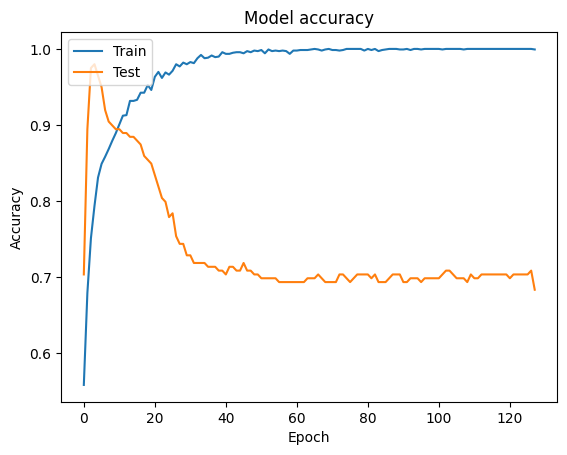

In [7]:
train_org, test_org, evaluation = read_data()
X_train, Y_train, X_valid, Y_valid, X_eval, Y_eval = prepare_data(train_org, test_org, evaluation)
model, history = create_model(X_train, Y_train, X_valid, Y_valid, X_eval, Y_eval)
conf_TP, conf_TN = evaluate(model, X_eval, Y_eval)
model_accuracy_figure(history)

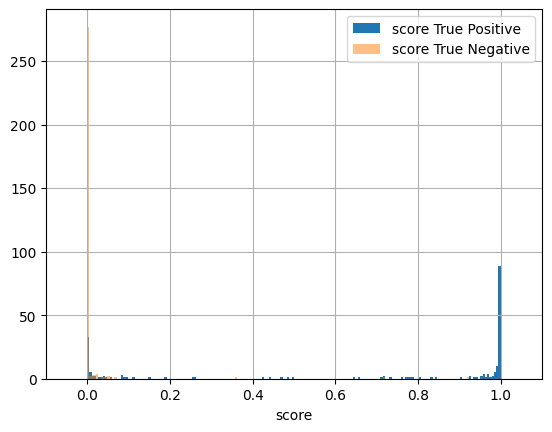

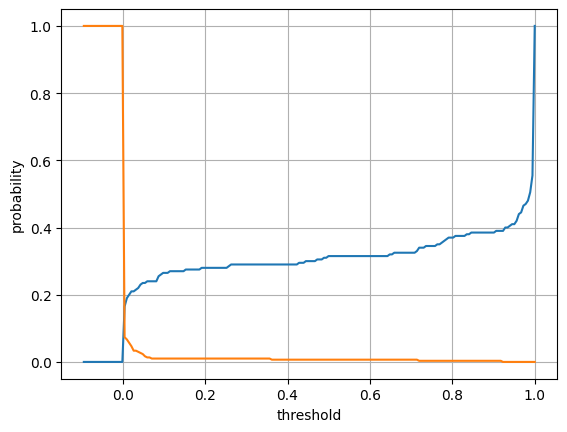

[0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0, 30.0]


<Figure size 1000x1000 with 0 Axes>

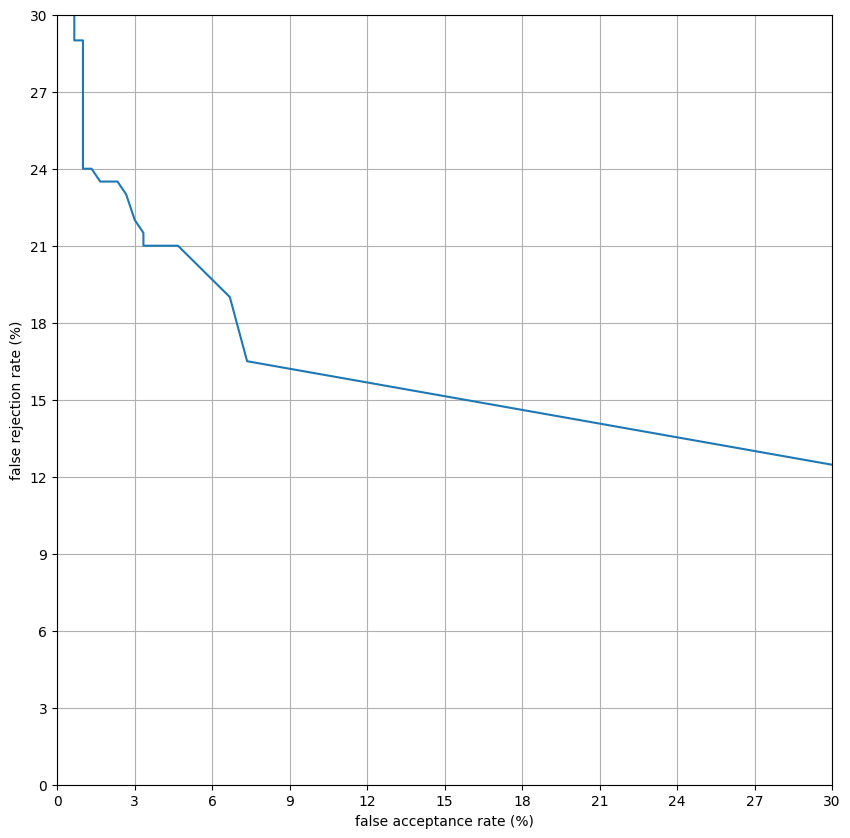

In [10]:
def confidence_figure(confidence_TP_MLP, confidence_TN_MLP):
    # Number of true negatives vs number of true positives
    plt.figure()
    n_TP, bins_TP, patches_TP = plt.hist(confidence_TP_MLP, alpha=1, bins=200, range=(-0.1, 1))
    n_TN, bins_TN, patches_TN = plt.hist(confidence_TN_MLP, alpha=0.5, bins=200, range=(-0.1, 1))
    plt.legend(["score True Positive", "score True Negative"])
    plt.xlim([-0.1, 1.1])
    plt.xlabel("score")
    plt.grid()
    plt.savefig("./plots/confidence_TP_TN.png")
    plt.show(block=False)

    # Probability of true negatives based on the threshold
    plt.figure()
    plt.plot(bins_TP[1:], np.cumsum(n_TP) / np.sum(n_TP))
    plt.plot(bins_TN[1:], 1 - (np.cumsum(n_TN) / np.sum(n_TN)))
    plt.grid()
    plt.xlabel("threshold")
    plt.ylabel("probability")
    plt.savefig("./plots/threshold_probability.png")
    plt.show(block=False)

    tn_sum = np.sum(n_TN)
    tp_sum = np.sum(n_TP)

    frr = np.cumsum(n_TP)
    for i in range(len(frr)):
        frr[i] /= tp_sum

    far = np.cumsum(n_TN)
    for i in range(len(far)):
        far[i] /= tn_sum
        far[i] = 1 - far[i]

    # DET CURVE
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 10))
    # plt.yscale('log')
    # plt.xscale('log')
    
    start = 15
    stop = 
    
    ticks_to_use = [start + ((stop - start) *  (x / 10))  for x in range(0, 11)]
    print(ticks_to_use)
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.plot(far * 100, frr * 100)
    plt.axis([start, stop, start, stop])
    plt.grid()
    plt.xlabel('false acceptance rate (%)')
    plt.ylabel('false rejection rate (%)')
    plt.savefig("./plots/det_curve.png")
    plt.show(block=False)
    
confidence_figure(conf_TP, conf_TN)

In [9]:
# SAVE FAR FRR TO CRAETE A GENERAL DET CURVE AT THE END
import json

with open("all_data.json", 'r') as file:
    new_data = json.load(file)

print(new_data)

new_data["dhakal"]["dedicated"][str(USERS)][str(PROBE_SIZE)] = {"TP": [], "TN": []}
new_data["dhakal"]["dedicated"][str(USERS)][str(PROBE_SIZE)]["TP"] = np.array(conf_TP).tolist()
new_data["dhakal"]["dedicated"][str(USERS)][str(PROBE_SIZE)]["TN"] = np.array(conf_TN).tolist()

print(new_data)
    
with open("all_data.json", 'w') as file:
    json_string = json.dumps(new_data)
    file.write(json_string)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

